<h1>Regression with Momentum ( RMS Prop, Adam)

<h3>Cylinder Volume Prediction</h3>
<p> As a chanllage we gernerated Training data with some radius and height using formula 
    $volume=\pi r^2 h$   where r is radius and h is height. Now we will train using either algo and will try to predict new data. As we try to fit the data, it converages very slow and requires some momentum algorithm like RMS Prop OR Adam.

<h5>Using Polynomial Regresion of degree 3 in two variables x and y</h5>
<p>
$h(x) = w_0 + w_1 x+ w_2 y + w_3 x^2 + w_4 x y + w_5 y^2 + w_6 y^3  + w_7 x y^2 + w_8 x^2 y + w_9 x^3 $
  
</p> 

<h3>Gradient Descent</h3>
   Normally we update gradient as
<p>$W := W - \alpha  DW $

<h3>With Momentum</h3>
    <p>$\beta1:=0.9$
    <p>$vDW:=\beta1  (vDW) +(1-\beta1) DW$
    <p>$W := W - \alpha  (vDW) $

<h3>With RMS Prop</h3>
    <p>$\beta2:=0.99$
    <p>$sDW:=\beta2  (sDW) +(1-\beta2) (Dw)^2$
    <p>$W := W - \alpha \frac{DW}{\sqrt{sDW}}  $
 <h3>With Adam</h3>
     <p>$\beta1:=0.9$
    <p>$\beta2:=0.99$
     <p>$vDW:=\beta1 (vDW) +(1-\beta1) (DW) $
    <p>$sDW:=\beta2  (sDW) +(1-\beta2) (DW)^2 $ 
     <p> Bias Correction  
    <p>$vDWc:=\frac{vDW}{(1-\beta1^k)} $     where K is iteration 
    <p>$sDWc:=\frac{sDW}{(1-\beta2^k)} $     
    <p>$W := W - \alpha \frac{vDWc}{\sqrt{sDWc}}$
    

In [1]:
import numpy as np 
import pandas as pd 
import sklearn.utils as skutils
import sklearn.model_selection as skmodelsel
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

<H1>Read Data from CSV

In [2]:
df = pd.read_csv('../input/CylinderVolumeDS/CylinderVolume.csv')   #Training Dataset
df = skutils.shuffle(df)
dfTrain, dfValid = skmodelsel.train_test_split(df, test_size=0.2)
dfTrain.head()

,rowid,radius,height,volume
2947,2948,24.0,14.5,26238.581843
6853,6854,27.0,34.0,77867.515512
9589,9590,45.0,47.5,302181.943367
2038,2039,19.5,10.0,11945.906065
2636,2637,18.5,13.0,13977.731114


<h5> Visualize Data

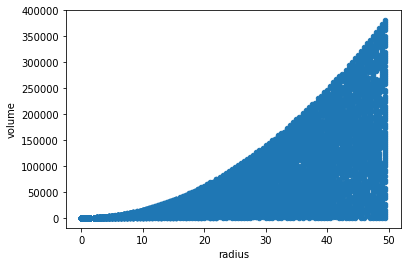

In [3]:
dfTrain.plot(x='radius',y='volume',kind='scatter')

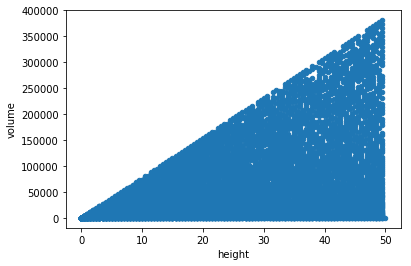

In [4]:
dfTrain.plot(x='height',y='volume',kind='scatter')

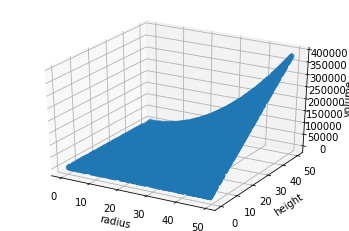

In [5]:
#%matplotlib notebook
plt3D = plt.figure().gca(projection='3d')
plt3D.scatter(dfTrain['radius'], dfTrain['height'], dfTrain['volume'])
plt3D.set_xlabel('radius')
plt3D.set_ylabel('height')
plt3D.set_zlabel('volume')
plt.show()

<h1>Extract Input Feature to <b>X </b>and Label to <b>y</b>

In [6]:
def extractFeatures(df):
    df_Features=df.loc[:,['radius','height']]
    df_Label=df.loc[:,['volume']]
    X=df_Features.values
    Y=df_Label.values
    return X,Y

In [7]:
X,Y=extractFeatures(dfTrain)

<h5>Normalize Input    

In [8]:
SMean=np.min(X,axis=0)    #using Min-Max Normalization
SDev=np.max(X,axis=0)
def NormalizeInput(X,SMean,SDev):   
    XNorm=(X-SMean)/SDev
    return XNorm

In [9]:
XNorm=NormalizeInput(X,SMean,SDev)

<h5>Add Polynomial Features

In [10]:
def mapFeature(X,degree):
    
    sz=X.shape[1]
    if (sz==2):
        sz=(degree+1)*(degree+2)/2
        sz=int(sz)
    else:
         sz=degree+1
    out=np.ones((X.shape[0],sz))     #Adding Bias W0

    sz=X.shape[1]
    if (sz==2):
        X1=X[:, 0:1]
        X2=X[:, 1:2]
        col=1
        for i in range(1,degree+1):        
            for j in range(0,i+1):
                out[:,col:col+1]= np.multiply(np.power(X1,i-j),np.power(X2,j))    
                col+=1
        return out
    else:
        for i in range(1,degree+1):        
            out[:,i:i+1]= np.power(X,i)
    
    return out

In [11]:
degree=3
inputX=mapFeature(XNorm,degree)  

<h1> Training

<h5> Initialization

In [12]:
batchSize=len(Y)         #no of Examples
iterations = 10000
alpha = 1000000000
beta1=0.99
beta2=0.999
learningDecayRate=0.9998
epsilon=0.0000000001
featureCount=inputX.shape[1] 
weights=np.zeros((featureCount, 1)) #initialize Weight Paramters
vDW=np.zeros((featureCount, 1))
sDW=np.zeros((featureCount, 1))
lossList=np.zeros((iterations,1),dtype=float)  #for plotting loss curve

<h5> Gradient Descent Updates

In [13]:

for k in range(iterations):
    #nth iteration
    t=k+1
    
    #Hypothesis
    hypothesis=np.matmul( inputX,weights)           
    
    #Loss
    loss=hypothesis-Y  
    
    
    #derivative
    dW=np.matmul(inputX.T,loss)  #Derivative
   
    #learning Rate decrease as training progresses 
    alpha=alpha*learningDecayRate
    
    #gradient Update
    vDW = (beta1) *vDW+ (1-beta1) *dW        #Momentum  
    sDW = (beta2) *sDW+ (1-beta2) *(dW**2)   #RMSProp
    
    vDWc =vDW/(1-beta1**t)
    sDWc =sDW/(1-beta2**t)
    
    #weights=weights - (alpha/batchSize)*vDW     #Momentum   
    #weights=weights - (alpha/batchSize)*dW/np.sqrt(csDW+epsilon)     #RMSProp 
    weights=weights - (alpha/batchSize)*(vDWc/(np.sqrt(sDWc)+epsilon)) #Adam          
    
    
    #Compute Loss for Plotting
    newLoss=np.matmul( inputX,weights)-Y
    newLossSqr=np.multiply(newLoss,newLoss)
    lossList[k]=(1.0/(2.0*batchSize))* np.sum(newLossSqr)

print("{0:.15f}".format(lossList[iterations-1][0]))

0.000000000000000


<h1>Plot Loss Curve

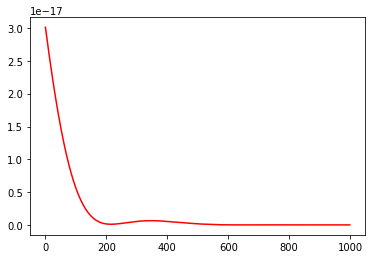

In [14]:
plt.plot(lossList[9000:10000],color='r')


<h1> Prediction/RMSE Evaluation

In [15]:
def predict(X,weights,SMean,SDev,degree):
    XNorm=NormalizeInput(X,SMean,SDev)
    inputX=mapFeature(XNorm,degree)
    PY=np.matmul(inputX, weights)
    return PY


In [16]:
def getRMSE(aY,pY):
    Error=aY- pY
    ErrorSqr=Error**2
    MSE=ErrorSqr.mean()
    RMSE=np.sqrt(MSE)
    return RMSE

<h5>RMSE on Training Data

In [17]:
pY=predict(X, weights,SMean,SDev,degree)  # Predict with bias feature added
print("{0:.15f}".format(getRMSE(Y, pY)))

0.000000000288460


<h5> RMSE on Validation Data

In [18]:
vX,vY=extractFeatures(dfValid)
pY=predict(vX, weights,SMean,SDev,degree)  # Predict with bias feature added
print("{0:.15f}".format(getRMSE(vY, pY)))

0.000000000291640


<h2> Model Final Verification (Try different values Manually)

In [19]:
radius=189
height=177
pi=3.14159265358979   #Same as Excel Function correct upto 15 decimal places
Volume=pi*radius**2*height
print("{0:.10f}".format(Volume))

19863087.1186619177


In [20]:
pY=predict([[radius,height]], weights,SMean,SDev,degree)  # Predict with bias feature added
print("{0:.10f}".format(pY[0][0]))

19863087.1186618879
